In [1]:
# run the data story to get data wrangling and data story variables
%run ./data_story.ipynb

E-Bikes dropped: 338834
Original scooter entries: 6510117
NA rows dropped: 130
Out of Bounds entries dropped: 52981
Before removing outliers:


<Figure size 1000x500 with 2 Axes>

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965
After removing outliers:


<Figure size 1000x500 with 2 Axes>

Total entries remaining: 5949360
Percent removed: 8.61362399477613%
Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object


<Figure size 1000x500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Number of Census Tract Starts: 256
Number of Census Tract Ends: 257
Number of unique Census Tracts in the data: 271


<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Top 4 starting location counts by day:


<Figure size 1000x500 with 4 Axes>

Top 4 ending location counts by day:


<Figure size 1000x500 with 4 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

In [12]:
# import modules
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from IPython.core.debugger import set_trace
scooters.head()

,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End,start_lat,start_long,end_lat,end_long
0,4d1e7bd0-75ce-401c-a802-8dd87122f802,scooter,678.0,2785.0,2019-04-27 15:00:00,2019-04-27 15:15:00,2019-04-28 02:42:07,4,15,6,1.0,9.0,2019,48453001100,48453001100,30.266479,-97.742663,30.266479,-97.742663
1,fdc38815-fe35-454b-bfb9-a63a2f2c205b,scooter,713.0,2466.0,2019-04-27 15:00:00,2019-04-27 15:15:00,2019-04-28 02:42:07,4,15,6,9.0,5.0,2019,48453001305,48453001901,30.251598,-97.755447,30.250269,-97.786240
2,007f1fed-0fe6-423f-8ca7-cd67834f20da,scooter,469.0,1608.0,2019-04-27 15:15:00,2019-04-27 15:15:00,2019-04-28 02:42:07,4,15,6,9.0,9.0,2019,48453001100,48453001305,30.266479,-97.742663,30.251598,-97.755447
3,672b17a6-6916-4f4e-a4e4-8168d623f638,scooter,644.0,1326.0,2019-04-27 15:15:00,2019-04-27 15:15:00,2019-04-28 02:42:07,4,15,6,9.0,9.0,2019,48453001305,48453001100,30.251598,-97.755447,30.266479,-97.742663
4,10e6b006-c5c5-4012-8f73-1ece7b7d19c1,scooter,419.0,1511.0,2019-04-27 15:15:00,2019-04-27 15:15:00,2019-04-28 02:42:07,4,15,6,3.0,1.0,2019,48453000902,48453000804,30.259192,-97.715970,30.270091,-97.721945


In [13]:
scooters.head()

# create a row for every hour
def ct_by_hour(df, census_tract, sample='H', end=False):
    
    if end:
        ct_df = pd.DataFrame(df[df['Census Tract End']==census_tract])
    else:
        ct_df = pd.DataFrame(df[df['Census Tract Start']==census_tract])
    
    # add a n column to sample
    ct_df['n'] = 1
    
    # resample at sample rate.  Use mean for distance/duration.  Also use mean to preserve datetime related values.
    # Use sum for n
    ct_df = ct_df.set_index('Start Time').resample(sample).agg({'Trip Duration': np.mean, 
                                                               'Trip Distance': np.mean,
                                                               'Month': np.mean,
                                                               'Day of Week': np.mean,
                                                               'Hour': np.mean,
                                                               'Year': np.mean,
                                                               'n': np.sum})
    
    
    # drop nas
    ct_df = ct_df.dropna()
    
    # Add day of month
    ct_df['Day of Month'] = ct_df.index.day
    
    
    # Return date and tiem columns.  Don't use duration and distance, as they would make better targets
    return ct_df[['Year', 'Month', 'Day of Month', 'Day of Week', 'Hour', 'n']]


In [14]:
ct_1100_hourly = ct_by_hour(scooters, '48453001100')


In [15]:
ct_1100_hourly.head()

,Year,Month,Day of Month,Day of Week,Hour,n
Start Time,,,,,,
2018-04-04 17:00:00,2018.0,4.0,4,3.0,17.0,1
2018-04-05 13:00:00,2018.0,4.0,5,4.0,13.0,6
2018-04-05 14:00:00,2018.0,4.0,5,4.0,14.0,4
2018-04-05 15:00:00,2018.0,4.0,5,4.0,15.0,2
2018-04-05 17:00:00,2018.0,4.0,5,4.0,17.0,1


In [16]:
def run_regression(clf, census_tract, source_df=scooters):
    # Create features and target
    df = ct_by_hour(source_df, census_tract)
    
    X = df[['Year', 'Month', 'Day of Month', 'Day of Week', 'Hour']]
    y = df['n']

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
    clf.fit(X_train, y_train)

    # Predict on test data
    y_pred = clf.predict(X_test)

    plt.scatter(range(len(y_pred)), y_pred, c='b', alpha=0.1)
    plt.scatter(range(len(y_test)), y_test, c='r', alpha=0.1)
    plt.legend(['Predicted', 'Actual'])
    plt.title(str(clf))
    plt.show()
    plt.close()

    print(f'{str(clf)} predicts with a R^2 score of {clf.score(X_test, y_test)}')

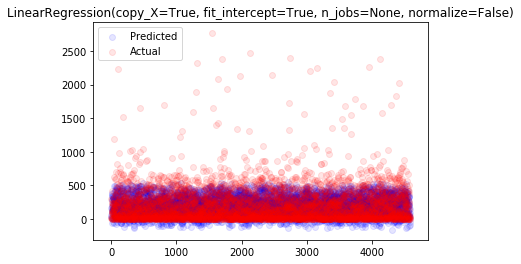

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) predicts with a R^2 score of 0.27827802945073254


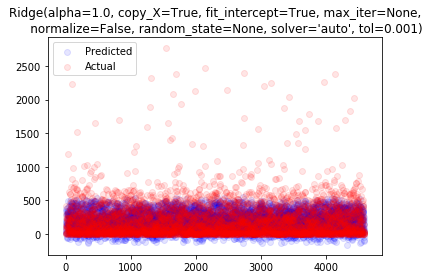

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) predicts with a R^2 score of 0.27829038628073577


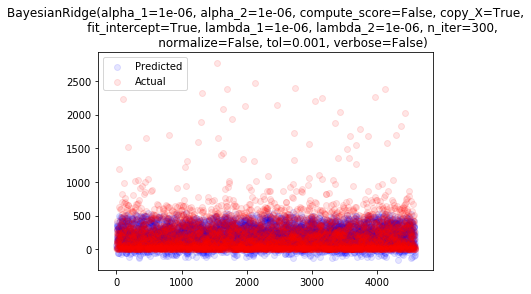

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False) predicts with a R^2 score of 0.2783320310631625


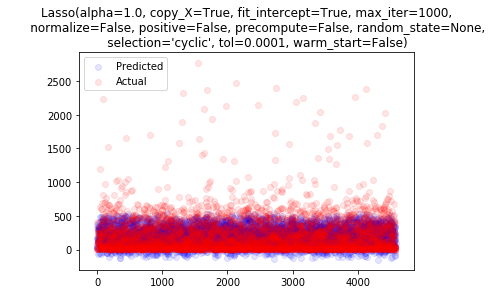

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) predicts with a R^2 score of 0.27873048462956806


In [17]:
regressions = [LinearRegression(), Ridge(), BayesianRidge(), Lasso()]

for regression in regressions:
    run_regression(regression, '48453001100')

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Number of Rides')
plt.ylabel('Predicted Number of Rides')
plt.title('Linear Regression')
plt.show()

In [ ]:
# Set up Ridge regression classifier

clf = Ridge()

# Fit classifier to training data
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

plt.scatter(range(len(y_pred)), y_pred, c='b', alpha=0.1)
plt.scatter(range(len(y_test)), y_test, c='r', alpha=0.1)
plt.legend(['Predicted', 'Actual'])

print(f'Bayesian Ridge Regression predicts with a R^2 score of {clf.score(X_test, y_test)}')


In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Number of Rides')
plt.ylabel('Predicted Number of Rides')
plt.title('Bayesian Ridge Regression')